In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,log_loss
from sklearn.preprocessing import LabelEncoder

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import shap


In [2]:
# Load and preprocess the data
df = pd.read_csv("dungeon performance ranks 28.01 - 24.02.csv")  # Replace with your data file path
df


,userId,dungeonId,sessionId,eventType,PartyMembers,entryTime,exitTime,duration,gameTime,min_fps,...,median_fps,p75_fps,p10_fps,min_ping,max_ping,p25_ping,median_ping,p75_ping,p90_ping,rn
0,01JJP0D87N8MNWKDXDTAMQFCNN,NaN,01JJSPP823VSDDBDCY94NAWHSK,extraction,2,2025-01-29 18:55:37.499 UTC,2025-01-29 18:59:27.5 UTC,0-0 0 0:3:50.001,114,42.526154,...,61.835065,68.217187,45.441178,220.80,372.500,233.90,253.200,287.70,315.80,14
1,01JJP0D87N8MNWKDXDTAMQFCNN,NaN,01JJSR5JY1K39W0J2S5P3D72WQ,extraction,3,2025-01-29 19:21:28.499 UTC,2025-01-29 19:24:47.5 UTC,0-0 0 0:3:19.001,132,34.921270,...,43.457030,51.310392,40.347834,232.90,327.600,235.60,259.600,276.70,301.30,15
2,01JJP0D87N8MNWKDXDTAMQFCNN,NaN,01JJSRH2KN07S5ZMP9JZ2BWH7M,extraction,3,2025-01-29 19:27:45.5 UTC,2025-01-29 19:33:18.499 UTC,0-0 0 0:5:32.999,219,26.352313,...,43.911825,56.552065,36.849332,246.00,975.500,264.40,278.400,305.70,405.60,16
3,01JJP0D87N8MNWKDXDTAMQFCNN,NaN,01JJTNPCZ8ZZJJZERECTSVAMHR,extraction,2,2025-01-30 03:57:29.5 UTC,2025-01-30 04:12:26.499 UTC,0-0 0 0:14:56.999,628,22.126079,...,45.265802,57.685595,28.280473,216.90,340.800,236.30,253.600,282.20,302.80,17
4,01JJP0D87N8MNWKDXDTAMQFCNN,NaN,01JJTVJQY783CAFNZKPNGJHB3X,extraction,3,2025-01-30 05:40:21.5 UTC,2025-01-30 05:55:40.5 UTC,0-0 0 0:15:19,582,20.402400,...,39.660907,50.328172,27.556507,220.90,336.600,241.00,255.400,273.30,295.00,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102861,01JK7E6ZN1BGG0D0YD0VDW6JAT,dc_desert_tier1,01JK9ZN910V2NTFKJG6H9X9HC2,extraction,1,2025-02-05 02:40:14.5 UTC,2025-02-05 02:57:33.5 UTC,0-0 0 0:17:19,691,27.497160,...,38.550253,49.107226,29.400105,255.90,346.500,270.60,275.800,296.30,326.20,13
102862,01JKENE8TPC7F2CZAARE7ZYKB5,dc_desert_tier1,01JKJKF3RWKSQWW7C0T8QW3PDA,extraction,1,2025-02-08 11:00:14.5 UTC,2025-02-08 11:10:58.499 UTC,0-0 0 0:10:43.999,522,54.097725,...,96.735961,110.210723,69.673873,75.60,154.900,85.30,87.100,103.20,109.20,13
102863,01JMDYX480470A5F35MXZHZ52J,dc_desert_tier1,01JME33K5T6V9K9XTPZ0TPWVVZ,died,1,2025-02-19 03:13:08.5 UTC,2025-02-19 03:28:02.5 UTC,0-0 0 0:14:54,548,12.488598,...,23.486852,30.634035,15.958845,72.70,422.100,97.40,131.500,151.50,175.80,13
102864,01JMJAD8J8T0PVFJ44XJC0V2EP,dc_desert_lush_tier1,01JMK9BKF8F9BZ45XN0476YV7P,extraction,1,2025-02-21 03:38:29.499 UTC,2025-02-21 03:50:36.5 UTC,0-0 0 0:12:7.001,466,34.621090,...,61.466281,80.305160,41.589400,79.34,210.560,101.84,127.000,167.46,183.58,13


In [3]:
df.columns

Index(['userId', 'dungeonId', 'sessionId', 'eventType', 'PartyMembers',
       'entryTime', 'exitTime', 'duration', 'gameTime', 'min_fps', 'max_fps',
       'p25_fps', 'median_fps', 'p75_fps', 'p10_fps', 'min_ping', 'max_ping',
       'p25_ping', 'median_ping', 'p75_ping', 'p90_ping', 'rn'],
      dtype='object')

In [4]:
cutoff_date = pd.Timestamp('2025-02-24 00:00:00', tz='UTC')
churn_window = pd.Timedelta(days=14)


In [5]:
user_churn = (
    df.groupby('userId')
      .agg(last_exit=('exitTime', 'max'), first_exit=('exitTime', 'min'),
           churn_run=('rn', 'max'))
      .reset_index()
)
user_churn['last_exit'] = pd.to_datetime(user_churn['last_exit'], utc=True)
user_churn['first_exit'] = pd.to_datetime(user_churn['first_exit'], utc=True)

# A user is considered churned if their last exit was at least 14 days before the cutoff date
user_churn['has_churned'] = (cutoff_date - user_churn['last_exit']) >= churn_window

# For churned users, record the run at which they churned; otherwise, mark as NaN
user_churn['churned_after'] = np.where(user_churn['has_churned'], user_churn['churn_run'], np.nan)

# Merge churn info back into the main dataframe
df = df.merge(user_churn[['userId', 'has_churned', 'churned_after']], on='userId', how='left')

df.sort_values(['userId', 'entryTime'], inplace=True)



# Define aggregation functions:
# - For performance metrics (fps and ping), use median.
# - For entryTime, take the first (min) and for exitTime, the last (max).
# - For duration and gameTime, you might sum them up.
# - For rn (run number), we take the maximum.
# - For some categorical columns, we can either take the first occurrence or list the unique values.
agg_dict = {
    'entryTime': 'min',
    'exitTime': 'max',
    'duration': 'sum',
    'gameTime': 'sum',
    'min_fps': 'median',
    'max_fps': 'median',
    'p25_fps': 'median',
    'median_fps': 'median',
    'p75_fps': 'median',
    'p10_fps': 'median',
    'min_ping': 'median',
    'max_ping': 'median',
    'p25_ping': 'median',
    'median_ping': 'median',
    'p75_ping': 'median',
    'p90_ping': 'median',
    'rn': 'max',
    # For categorical/string columns, you can adjust as needed.
    'dungeonId': lambda x: list(x.unique()),    # List all unique dungeonIds played
    'sessionId': lambda x: list(x.unique()),    # List all unique sessionIds
    'eventType': lambda x: list(x.unique()),      # List all event types seen
    'PartyMembers': 'first'                       # Or use a lambda if you need to combine multiple values
}

# Aggregate by userId
df_agg = df.groupby('userId').agg(agg_dict).reset_index()

# Merge churn info (has_churned and churned_after) into the aggregated dataframe
df_churn = user_churn[['userId', 'has_churned', 'churned_after']]
df_agg = df_agg.merge(df_churn, on='userId', how='left')

# Display the aggregated dataframe
print(df_agg.head())

                       userId                    entryTime  \
0  01HV74Y9CEMS2PHHPT5YN624RC    2025-01-30 18:28:37.5 UTC   
1  01HV756HDWZRKHFN812YFJCHQA  2025-01-30 19:30:26.499 UTC   
2  01HV75DS0BQ9FK0HYFM1PAA095    2025-02-07 13:26:47.5 UTC   
3  01HV76M4PWSPCECR7VM2TG96K2  2025-01-30 10:57:49.499 UTC   
4  01HV7BYZ6ADT6DVJKV6EBH1P3Y    2025-01-28 15:02:58.5 UTC   

                      exitTime  \
0    2025-02-20 18:55:42.5 UTC   
1  2025-02-16 21:23:02.499 UTC   
2    2025-02-07 13:48:20.5 UTC   
3    2025-02-20 14:28:53.5 UTC   
4    2025-02-03 11:40:05.5 UTC   

                                            duration  gameTime     min_fps  \
0  0-0 0 0:2:310-0 0 0:3:430-0 0 0:1:8.0010-0 0 0...       470  111.443241   
1  0-0 0 0:0:13.0010-0 0 0:0:18.0010-0 0 0:0:70-0...       453  104.782460   
2               0-0 0 0:2:550-0 0 0:2:540-0 0 0:2:59       436  133.993333   
3  0-0 0 0:0:14.0010-0 0 0:1:8.0010-0 0 0:2:47.99...      1186  109.412846   
4               0-0 0 0:3:390-0 

In [6]:
df_agg['has_churned'] = (cutoff_date - user_churn['last_exit']) >= churn_window

df_agg

,userId,entryTime,exitTime,duration,gameTime,min_fps,max_fps,p25_fps,median_fps,p75_fps,...,median_ping,p75_ping,p90_ping,rn,dungeonId,sessionId,eventType,PartyMembers,has_churned,churned_after
0,01HV74Y9CEMS2PHHPT5YN624RC,2025-01-30 18:28:37.5 UTC,2025-02-20 18:55:42.5 UTC,0-0 0 0:2:310-0 0 0:3:430-0 0 0:1:8.0010-0 0 0...,470,111.443241,209.132647,116.516407,125.439514,166.747353,...,110.3775,123.9925,127.1475,6,"[dc_desert_tier1, dc_desert_gd_1, dc_desert_25...","[01JJW7HGNCJVE5CK036E4FH77M, 01JK901PGN3V04EG8...",[abandoned],1,False,NaN
1,01HV756HDWZRKHFN812YFJCHQA,2025-01-30 19:30:26.499 UTC,2025-02-16 21:23:02.499 UTC,0-0 0 0:0:13.0010-0 0 0:0:18.0010-0 0 0:0:70-0...,453,104.782460,128.057929,111.095356,112.771499,112.771499,...,285.2750,285.2750,289.0700,7,"[dc_desert_scorched_tier1, dc_desert_scorched_...","[01JJWB2VB98TG9VXNNFMHJEDHM, 01JJWB4JXZDRDHT3M...","[abandoned, died]",1,False,NaN
2,01HV75DS0BQ9FK0HYFM1PAA095,2025-02-07 13:26:47.5 UTC,2025-02-07 13:48:20.5 UTC,0-0 0 0:2:550-0 0 0:2:540-0 0 0:2:59,436,133.993333,288.254623,160.443222,170.108135,187.955677,...,117.5600,121.7800,125.9000,3,[dc_desert_tier1],"[01JKG9ER4GBC2004EB43VPQDCZ, 01JKGA2WMXSDRK9XK...",[extraction],1,True,3.0
3,01HV76M4PWSPCECR7VM2TG96K2,2025-01-30 10:57:49.499 UTC,2025-02-20 14:28:53.5 UTC,0-0 0 0:0:14.0010-0 0 0:1:8.0010-0 0 0:2:47.99...,1186,109.412846,209.429146,116.644975,142.147007,161.890299,...,112.0150,120.1250,123.2050,9,"[nan, dc_desert_tier1, dc_desert_gd_1, dc_dese...","[01JJVDR792DQZARFXN4H3M2GFN, 01JJVEBBQ2P7WSVJZ...","[abandoned, extraction, died]",1,False,NaN
4,01HV7BYZ6ADT6DVJKV6EBH1P3Y,2025-01-28 15:02:58.5 UTC,2025-02-03 11:40:05.5 UTC,0-0 0 0:3:390-0 0 0:1:180-0 0 0:0:45,255,89.766022,134.354600,89.766022,98.301841,105.484145,...,122.9950,124.9300,136.4200,3,"[nan, dc_desert_tier2]","[01JJPPZGJS9DNHP6E7EERQYYX1, 01JK5QT2Q3KKVY667...","[extraction, abandoned]",2,True,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34833,01JMVV71RRY91NRJZPMYANNE5W,2025-02-24 11:27:13.499 UTC,2025-02-24 11:28:03.5 UTC,0-0 0 0:0:50.001,47,60.149552,75.127396,60.149552,63.269962,75.127396,...,274.7050,306.4400,306.4400,1,[dc_tutorial_tier1],[01JMVVBWJEGDXBZ21J757HQZCV],[died],1,False,NaN
34834,01JMVV9QGF7C4BES3B0JQ9TBF2,2025-02-24 11:27:16.499 UTC,2025-02-24 11:30:15.5 UTC,0-0 0 0:1:8.0010-0 0 0:1:5.001,123,80.426003,151.102138,87.670697,96.648501,103.254359,...,260.4000,303.0000,329.9500,2,[dc_tutorial_tier1],"[01JMVVC49AEJDYT4QB4PY8KBS3, 01JMVVFE1XP04394P...",[died],1,False,NaN
34835,01JMVVKG26PDEY2NV41ZTWSBP1,2025-02-24 11:36:27.499 UTC,2025-02-24 11:41:11.5 UTC,0-0 0 0:4:44.001,180,26.424303,94.024673,33.524165,37.977898,60.424007,...,325.7000,331.3000,358.7000,1,[dc_tutorial_tier1],[01JMVVWSKT2QAVGZY5KS7D8NGJ],[extraction],2,False,NaN
34836,01JMVVKRSD0AEAZTJGDDWZYEYR,2025-02-24 11:36:27.499 UTC,2025-02-24 11:41:11.5 UTC,0-0 0 0:4:44.001,180,23.992636,57.667661,29.163958,30.773158,45.522349,...,319.0000,346.1000,392.5000,1,[dc_tutorial_tier1],[01JMVVWSKT2QAVGZY5KS7D8NGJ],[extraction],2,False,NaN


In [7]:
mask = (cutoff_date - user_churn['first_exit']) < churn_window
mask
df_agg = df_agg[~mask]

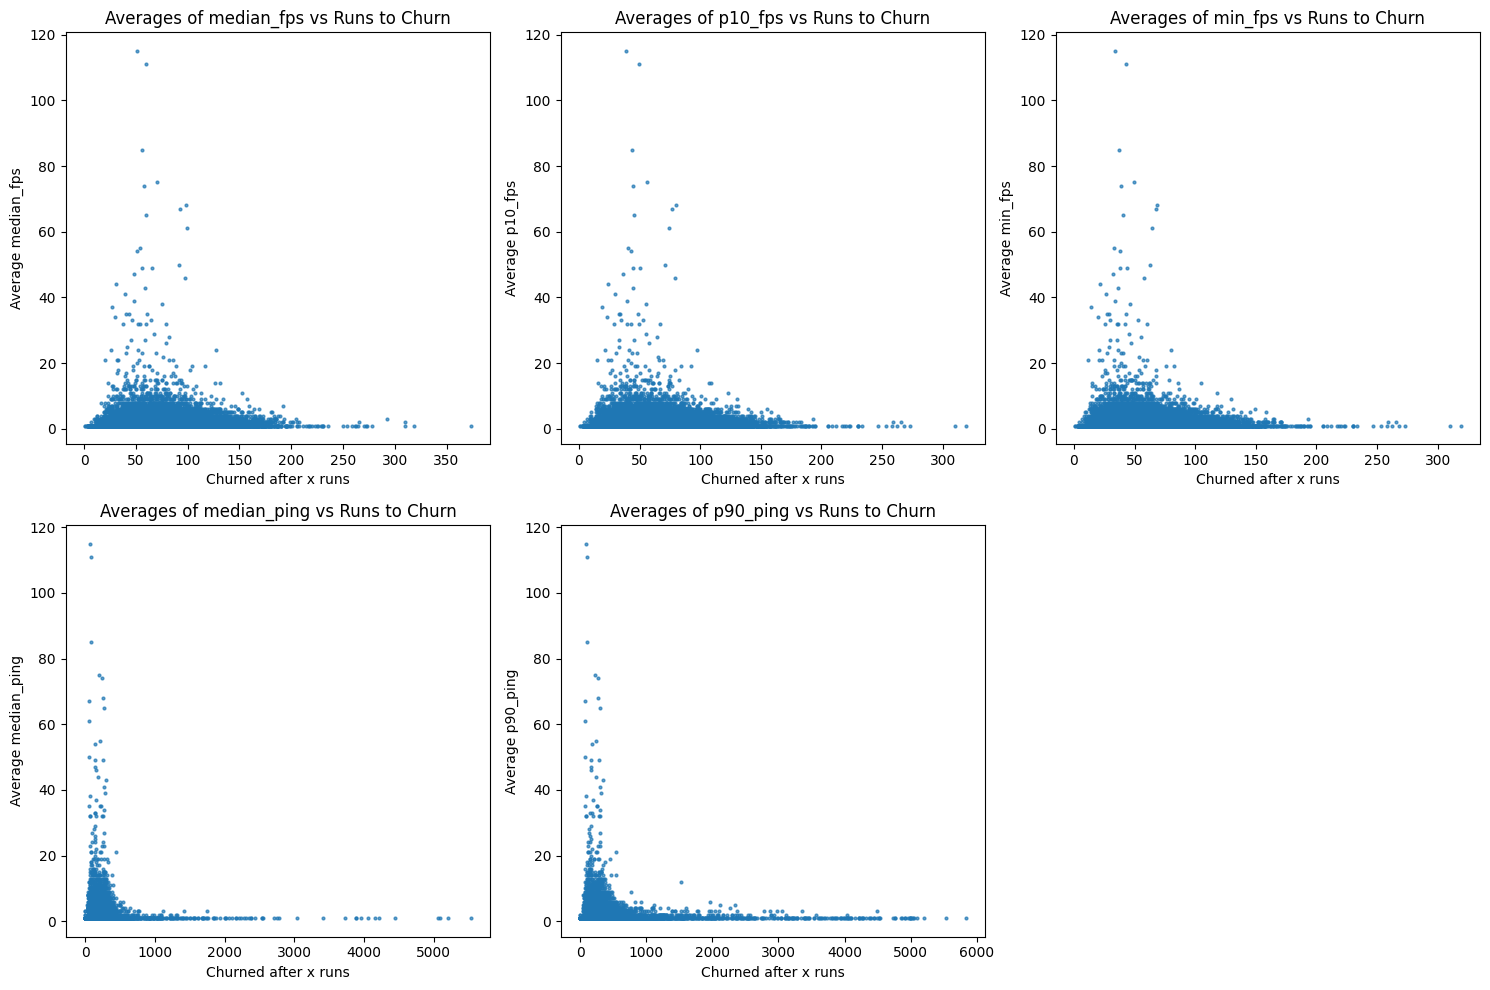

In [8]:
"""# Group data by userId and calculate averages for selected stats and the total number of runs till churn
grouped = df.groupby("userId").agg({
    "median_fps": "mean",
    "p10_fps": "mean",
    "min_fps": "mean",
    "median_ping": "mean",
    "p90_ping": "mean",
    "runs_to_churn": "max"
}).reset_index()
"""
# Plot averages for each stat against the number of dungeons they will run till churn
stats = ["median_fps", "p10_fps", "min_fps", "median_ping", "p90_ping"]

plt.figure(figsize=(15, 10))
for i, stat in enumerate(stats, 1):
    plt.subplot(2, 3, i)
    plt.scatter( df_agg[stat],df_agg["churned_after"], alpha=0.7, s = 4)
    plt.title(f"Averages of {stat} vs Runs to Churn")
    plt.xlabel("Churned after x runs")
    plt.ylabel(f"Average {stat}")

plt.tight_layout()
plt.show()


In [9]:
fps_bins = [0, 20, 30, 60, 120, float('inf')]
fps_labels = ['0-20 FPS', '20-30 FPS', '30-60 FPS', '60-120 FPS', '120+ FPS']
ping_bins = [0, 30, 60, 100, 200, float('inf')]
ping_labels = ['0-30 Ping', '30-60 Ping', '60-100 Ping', '100-200 Ping', '200+ Ping']

df_agg.loc[:, 'median_fps_category'] = pd.cut(
    df_agg['median_fps'], 
    bins=fps_bins, 
    labels=fps_labels
)
df_agg.loc[:, 'p10_fps_category'] = pd.cut(
    df_agg['p10_fps'], 
    bins=fps_bins, 
    labels=fps_labels
)
df_agg.loc[:, 'min_fps_category'] = pd.cut(
    df_agg['min_fps'], 
    bins=fps_bins, 
    labels=fps_labels
)
df_agg.loc[:, 'median_ping_category'] = pd.cut(
    df_agg['median_ping'], 
    bins=ping_bins, 
    labels=ping_labels
)
df_agg.loc[:, 'p90_ping_category'] = pd.cut(
    df_agg['p90_ping'], 
    bins=ping_bins, 
    labels=ping_labels
)

categories = ['median_fps_category','p10_fps_category','median_ping_category','p90_ping_category', 'min_fps_category']

/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_42754/1786367337.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg.loc[:, 'median_fps_category'] = pd.cut(
/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_42754/1786367337.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg.loc[:, 'p10_fps_category'] = pd.cut(
/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_42754/1786367337.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [10]:
print(df_agg['churned_after'].isnull().sum())  # Count missing values
print(df_agg['churned_after'].unique())       # Check for unexpected values

554
[ nan   3.  13.   2.   4.   6.  12.   1.   5.  33.  34.   9.  16.  43.
   7.  10.   8.  11.  19.  21.  24.  15.  74.  29.  14.  37.  18.  68.
  27.  32.  49.  38.  61.  54. 115.  67.  28. 111.  47.  17.  75.  55.
  35.  50.  46.  22.  39.  20.  65.  41.  44.  23.  85.  26.  25.]


In [11]:
df_agg

,userId,entryTime,exitTime,duration,gameTime,min_fps,max_fps,p25_fps,median_fps,p75_fps,...,sessionId,eventType,PartyMembers,has_churned,churned_after,median_fps_category,p10_fps_category,min_fps_category,median_ping_category,p90_ping_category
0,01HV74Y9CEMS2PHHPT5YN624RC,2025-01-30 18:28:37.5 UTC,2025-02-20 18:55:42.5 UTC,0-0 0 0:2:310-0 0 0:3:430-0 0 0:1:8.0010-0 0 0...,470,111.443241,209.132647,116.516407,125.439514,166.747353,...,"[01JJW7HGNCJVE5CK036E4FH77M, 01JK901PGN3V04EG8...",[abandoned],1,False,NaN,120+ FPS,60-120 FPS,60-120 FPS,100-200 Ping,100-200 Ping
1,01HV756HDWZRKHFN812YFJCHQA,2025-01-30 19:30:26.499 UTC,2025-02-16 21:23:02.499 UTC,0-0 0 0:0:13.0010-0 0 0:0:18.0010-0 0 0:0:70-0...,453,104.782460,128.057929,111.095356,112.771499,112.771499,...,"[01JJWB2VB98TG9VXNNFMHJEDHM, 01JJWB4JXZDRDHT3M...","[abandoned, died]",1,False,NaN,60-120 FPS,60-120 FPS,60-120 FPS,200+ Ping,200+ Ping
2,01HV75DS0BQ9FK0HYFM1PAA095,2025-02-07 13:26:47.5 UTC,2025-02-07 13:48:20.5 UTC,0-0 0 0:2:550-0 0 0:2:540-0 0 0:2:59,436,133.993333,288.254623,160.443222,170.108135,187.955677,...,"[01JKG9ER4GBC2004EB43VPQDCZ, 01JKGA2WMXSDRK9XK...",[extraction],1,True,3.0,120+ FPS,120+ FPS,120+ FPS,100-200 Ping,100-200 Ping
3,01HV76M4PWSPCECR7VM2TG96K2,2025-01-30 10:57:49.499 UTC,2025-02-20 14:28:53.5 UTC,0-0 0 0:0:14.0010-0 0 0:1:8.0010-0 0 0:2:47.99...,1186,109.412846,209.429146,116.644975,142.147007,161.890299,...,"[01JJVDR792DQZARFXN4H3M2GFN, 01JJVEBBQ2P7WSVJZ...","[abandoned, extraction, died]",1,False,NaN,120+ FPS,60-120 FPS,60-120 FPS,100-200 Ping,100-200 Ping
4,01HV7BYZ6ADT6DVJKV6EBH1P3Y,2025-01-28 15:02:58.5 UTC,2025-02-03 11:40:05.5 UTC,0-0 0 0:3:390-0 0 0:1:180-0 0 0:0:45,255,89.766022,134.354600,89.766022,98.301841,105.484145,...,"[01JJPPZGJS9DNHP6E7EERQYYX1, 01JK5QT2Q3KKVY667...","[extraction, abandoned]",2,True,3.0,60-120 FPS,60-120 FPS,60-120 FPS,100-200 Ping,100-200 Ping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18148,01JKPHWDAFVV1435WE06XV9QGG,2025-02-09 23:51:30.5 UTC,2025-02-09 23:55:15.5 UTC,0-0 0 0:3:45,136,43.312522,78.568366,51.989917,54.656988,66.104470,...,[01JKPHZX7VP23GY031XHQY2WFM],[extraction],3,True,1.0,30-60 FPS,30-60 FPS,30-60 FPS,100-200 Ping,100-200 Ping
18149,01JKPHWQSCTV6ATXQQ5BEGF56Y,2025-02-09 23:51:41.5 UTC,2025-02-09 23:55:44.5 UTC,0-0 0 0:4:3,136,36.254434,62.800736,36.254434,55.826790,58.506277,...,[01JKPJ080Y8E02BSCG3BDB1N29],[extraction],3,True,1.0,30-60 FPS,30-60 FPS,30-60 FPS,100-200 Ping,100-200 Ping
18150,01JKPJ0TE0BB8E2JPK8ZCCJCKQ,2025-02-09 23:53:32.499 UTC,2025-02-10 00:03:17.5 UTC,0-0 0 0:2:580-0 0 0:4:32.001,334,51.325423,95.849249,53.327609,62.557347,66.597355,...,"[01JKPJ3SPTS9X5QGNFRVVT2TVG, 01JKPJD6YWVE8YV7B...",[extraction],1,False,NaN,60-120 FPS,30-60 FPS,30-60 FPS,60-100 Ping,100-200 Ping
18151,01JKPJ1N9435H4FD4P33K43PRP,2025-02-09 23:54:08.499 UTC,2025-02-09 23:55:52.499 UTC,0-0 0 0:1:44,91,74.121492,98.164503,79.737789,81.433339,91.507714,...,[01JKPJ4XDCY0AV244WWVCS2R6W],[died],1,True,1.0,60-120 FPS,60-120 FPS,60-120 FPS,100-200 Ping,100-200 Ping


In [12]:
churn_bins = [0, 1.5, 3.5,10.5 ,float('inf')]
churn_labels = ['1', '2-3', '4-10', '10+']




In [13]:
# Bucket churn metrics
df_agg['churn_bin'] = pd.cut(df_agg['churned_after'].astype(float), 
                             bins=churn_bins, 
                             labels=churn_labels, 
                             right=False)

/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_42754/3453168654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['churn_bin'] = pd.cut(df_agg['churned_after'].astype(float),


In [14]:
df_agg

,userId,entryTime,exitTime,duration,gameTime,min_fps,max_fps,p25_fps,median_fps,p75_fps,...,eventType,PartyMembers,has_churned,churned_after,median_fps_category,p10_fps_category,min_fps_category,median_ping_category,p90_ping_category,churn_bin
0,01HV74Y9CEMS2PHHPT5YN624RC,2025-01-30 18:28:37.5 UTC,2025-02-20 18:55:42.5 UTC,0-0 0 0:2:310-0 0 0:3:430-0 0 0:1:8.0010-0 0 0...,470,111.443241,209.132647,116.516407,125.439514,166.747353,...,[abandoned],1,False,NaN,120+ FPS,60-120 FPS,60-120 FPS,100-200 Ping,100-200 Ping,NaN
1,01HV756HDWZRKHFN812YFJCHQA,2025-01-30 19:30:26.499 UTC,2025-02-16 21:23:02.499 UTC,0-0 0 0:0:13.0010-0 0 0:0:18.0010-0 0 0:0:70-0...,453,104.782460,128.057929,111.095356,112.771499,112.771499,...,"[abandoned, died]",1,False,NaN,60-120 FPS,60-120 FPS,60-120 FPS,200+ Ping,200+ Ping,NaN
2,01HV75DS0BQ9FK0HYFM1PAA095,2025-02-07 13:26:47.5 UTC,2025-02-07 13:48:20.5 UTC,0-0 0 0:2:550-0 0 0:2:540-0 0 0:2:59,436,133.993333,288.254623,160.443222,170.108135,187.955677,...,[extraction],1,True,3.0,120+ FPS,120+ FPS,120+ FPS,100-200 Ping,100-200 Ping,2-3
3,01HV76M4PWSPCECR7VM2TG96K2,2025-01-30 10:57:49.499 UTC,2025-02-20 14:28:53.5 UTC,0-0 0 0:0:14.0010-0 0 0:1:8.0010-0 0 0:2:47.99...,1186,109.412846,209.429146,116.644975,142.147007,161.890299,...,"[abandoned, extraction, died]",1,False,NaN,120+ FPS,60-120 FPS,60-120 FPS,100-200 Ping,100-200 Ping,NaN
4,01HV7BYZ6ADT6DVJKV6EBH1P3Y,2025-01-28 15:02:58.5 UTC,2025-02-03 11:40:05.5 UTC,0-0 0 0:3:390-0 0 0:1:180-0 0 0:0:45,255,89.766022,134.354600,89.766022,98.301841,105.484145,...,"[extraction, abandoned]",2,True,3.0,60-120 FPS,60-120 FPS,60-120 FPS,100-200 Ping,100-200 Ping,2-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18148,01JKPHWDAFVV1435WE06XV9QGG,2025-02-09 23:51:30.5 UTC,2025-02-09 23:55:15.5 UTC,0-0 0 0:3:45,136,43.312522,78.568366,51.989917,54.656988,66.104470,...,[extraction],3,True,1.0,30-60 FPS,30-60 FPS,30-60 FPS,100-200 Ping,100-200 Ping,1
18149,01JKPHWQSCTV6ATXQQ5BEGF56Y,2025-02-09 23:51:41.5 UTC,2025-02-09 23:55:44.5 UTC,0-0 0 0:4:3,136,36.254434,62.800736,36.254434,55.826790,58.506277,...,[extraction],3,True,1.0,30-60 FPS,30-60 FPS,30-60 FPS,100-200 Ping,100-200 Ping,1
18150,01JKPJ0TE0BB8E2JPK8ZCCJCKQ,2025-02-09 23:53:32.499 UTC,2025-02-10 00:03:17.5 UTC,0-0 0 0:2:580-0 0 0:4:32.001,334,51.325423,95.849249,53.327609,62.557347,66.597355,...,[extraction],1,False,NaN,60-120 FPS,30-60 FPS,30-60 FPS,60-100 Ping,100-200 Ping,NaN
18151,01JKPJ1N9435H4FD4P33K43PRP,2025-02-09 23:54:08.499 UTC,2025-02-09 23:55:52.499 UTC,0-0 0 0:1:44,91,74.121492,98.164503,79.737789,81.433339,91.507714,...,[died],1,True,1.0,60-120 FPS,60-120 FPS,60-120 FPS,100-200 Ping,100-200 Ping,1


In [15]:
# Add the new category 'Not churned' to the churn_bin categorical data
df_agg['churn_bin'] = df_agg['churn_bin'].cat.add_categories('Not churned')

# Now assign 'Not churned' to rows where the user has not churned
df_agg.loc[df_agg['has_churned'] == False, 'churn_bin'] = 'Not churned'


/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_42754/2449098545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['churn_bin'] = df_agg['churn_bin'].cat.add_categories('Not churned')


In [16]:
print(df_agg[['userId', 'churned_after', 'has_churned', 'churn_bin']][df_agg['has_churned']==True])


                           userId  churned_after  has_churned churn_bin
2      01HV75DS0BQ9FK0HYFM1PAA095            3.0         True       2-3
4      01HV7BYZ6ADT6DVJKV6EBH1P3Y            3.0         True       2-3
11     01HV7EMM1T9N4PMG1AA43HZNRJ           13.0         True       10+
17     01HV7F5WP9HR53R4FQZ4GAZ9AQ            2.0         True       2-3
20     01HV7FA166VCVVJJ7AM3NM6QHJ            2.0         True       2-3
...                           ...            ...          ...       ...
18147  01JKPHWD2M7NVPY4Q8X4CTM3ZM            1.0         True         1
18148  01JKPHWDAFVV1435WE06XV9QGG            1.0         True         1
18149  01JKPHWQSCTV6ATXQQ5BEGF56Y            1.0         True         1
18151  01JKPJ1N9435H4FD4P33K43PRP            1.0         True         1
18152  01JKPJ4R7D397B5DY4H2TS7V1C            1.0         True         1

[17023 rows x 4 columns]


/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_42754/3859879895.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '74.65%
(212)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_data.loc[row, col] = f"{heatmap_data_normalized.loc[row, col]:.2%}\n({heatmap_data.loc[row, col]})"
/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_42754/3859879895.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.61%
(50)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_data.loc[row, col] = f"{heatmap_data_normalized.loc[row, col]:.2%}\n({heatmap_data.loc[row, col]})"
/var/folders/lb/zdn8z8h52qj98k97p1vxq7jm0000gn/T/ipykernel_42754/3859879895.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and w

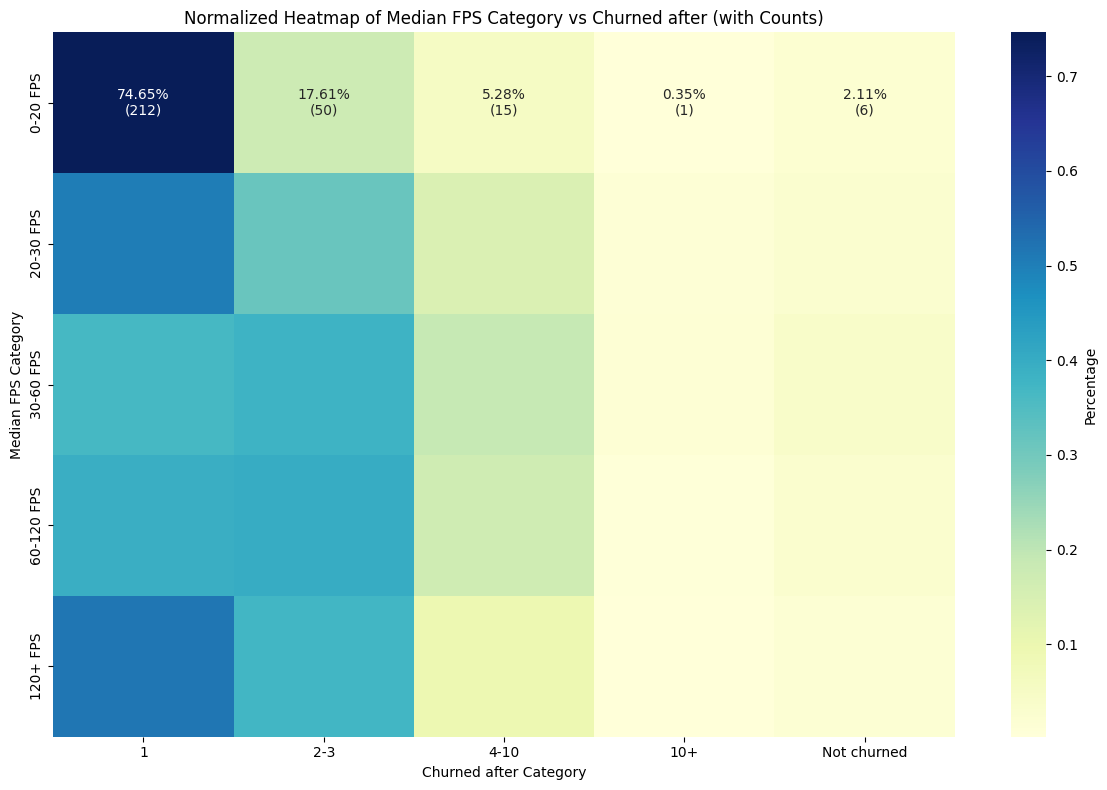

In [17]:

# Create a heatmap for median_fps_category vs runs_to_churn_category
heatmap_data = df_agg.pivot_table(
    index='median_fps_category',
    columns='churn_bin',
    aggfunc='size',
    fill_value=0,
    observed = False
)

# Normalize the heatmap data by row (percentage)
heatmap_data_normalized = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

# Combine normalized percentages and raw counts into a single DataFrame
annot_data = heatmap_data_normalized.copy()
for row in heatmap_data.index:
    for col in heatmap_data.columns:
        annot_data.loc[row, col] = f"{heatmap_data_normalized.loc[row, col]:.2%}\n({heatmap_data.loc[row, col]})"

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data_normalized, 
    annot=annot_data, 
    fmt="", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Percentage'}
)
plt.title("Normalized Heatmap of Median FPS Category vs Churned after (with Counts)")
plt.xlabel("Churned after Category")
plt.ylabel("Median FPS Category")
plt.tight_layout()
plt.show()


In [18]:
annot_data

churn_bin,1,2-3,4-10,10+,Not churned
median_fps_category,,,,,
0-20 FPS,74.65%\n(212),17.61%\n(50),5.28%\n(15),0.35%\n(1),2.11%\n(6)
20-30 FPS,50.48%\n(314),31.35%\n(195),14.47%\n(90),1.13%\n(7),2.57%\n(16)
30-60 FPS,36.82%\n(1698),38.17%\n(1760),19.11%\n(881),1.65%\n(76),4.25%\n(196)
60-120 FPS,39.41%\n(4065),39.88%\n(4114),16.95%\n(1748),0.79%\n(82),2.97%\n(306)
120+ FPS,51.58%\n(900),37.19%\n(649),9.28%\n(162),0.23%\n(4),1.72%\n(30)


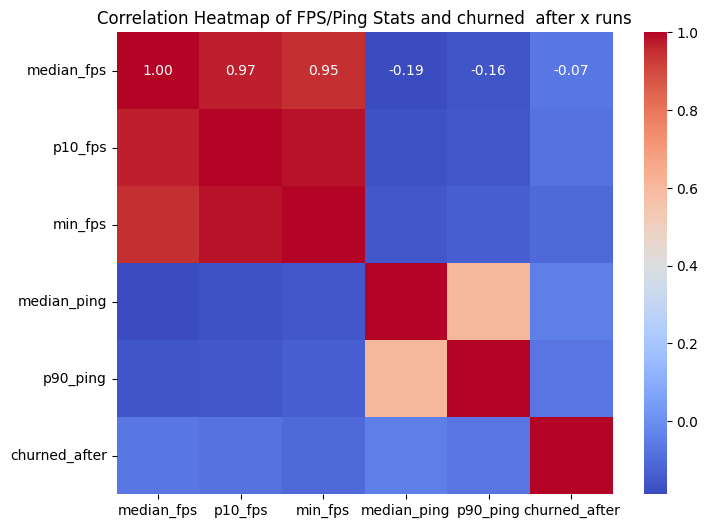

In [19]:
# Compute correlation matrix
correlation_matrix = df_agg[["median_fps", "p10_fps", "min_fps", "median_ping", "p90_ping", "churned_after"]].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of FPS/Ping Stats and churned  after x runs")
plt.show()

churn_bin                         1             2-3            4-10  \
median_fps_category                                                   
0-20 FPS              74.65%\n(212)    17.61%\n(50)     5.28%\n(15)   
20-30 FPS             50.48%\n(314)   31.35%\n(195)    14.47%\n(90)   
30-60 FPS            36.82%\n(1698)  38.17%\n(1760)   19.11%\n(881)   
60-120 FPS           39.41%\n(4065)  39.88%\n(4114)  16.95%\n(1748)   
120+ FPS              51.58%\n(900)   37.19%\n(649)    9.28%\n(162)   

churn_bin                    10+   Not churned  
median_fps_category                             
0-20 FPS              0.35%\n(1)    2.11%\n(6)  
20-30 FPS             1.13%\n(7)   2.57%\n(16)  
30-60 FPS            1.65%\n(76)  4.25%\n(196)  
60-120 FPS           0.79%\n(82)  2.97%\n(306)  
120+ FPS              0.23%\n(4)   1.72%\n(30)  


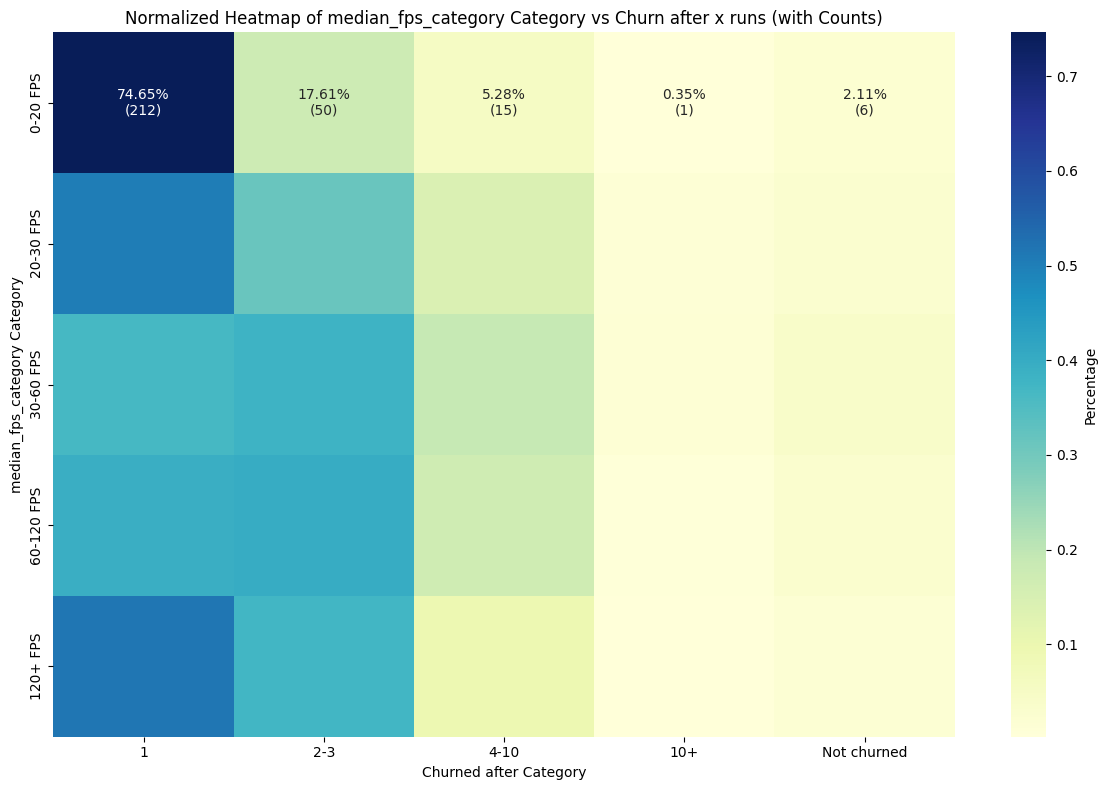

churn_bin                      1             2-3            4-10  \
p10_fps_category                                                   
0-20 FPS           58.05%\n(339)   27.91%\n(163)    10.96%\n(64)   
20-30 FPS          42.81%\n(518)   34.38%\n(416)   17.11%\n(207)   
30-60 FPS         35.96%\n(2435)  38.49%\n(2606)  20.01%\n(1355)   
60-120 FPS        41.66%\n(3436)  40.43%\n(3334)  14.88%\n(1227)   
120+ FPS           60.26%\n(461)   32.55%\n(249)     5.62%\n(43)   

churn_bin                  10+   Not churned  
p10_fps_category                              
0-20 FPS            0.68%\n(4)   2.40%\n(14)  
20-30 FPS          1.40%\n(17)   4.30%\n(52)  
30-60 FPS         1.49%\n(101)  4.05%\n(274)  
60-120 FPS         0.57%\n(47)  2.46%\n(203)  
120+ FPS            0.13%\n(1)   1.44%\n(11)  


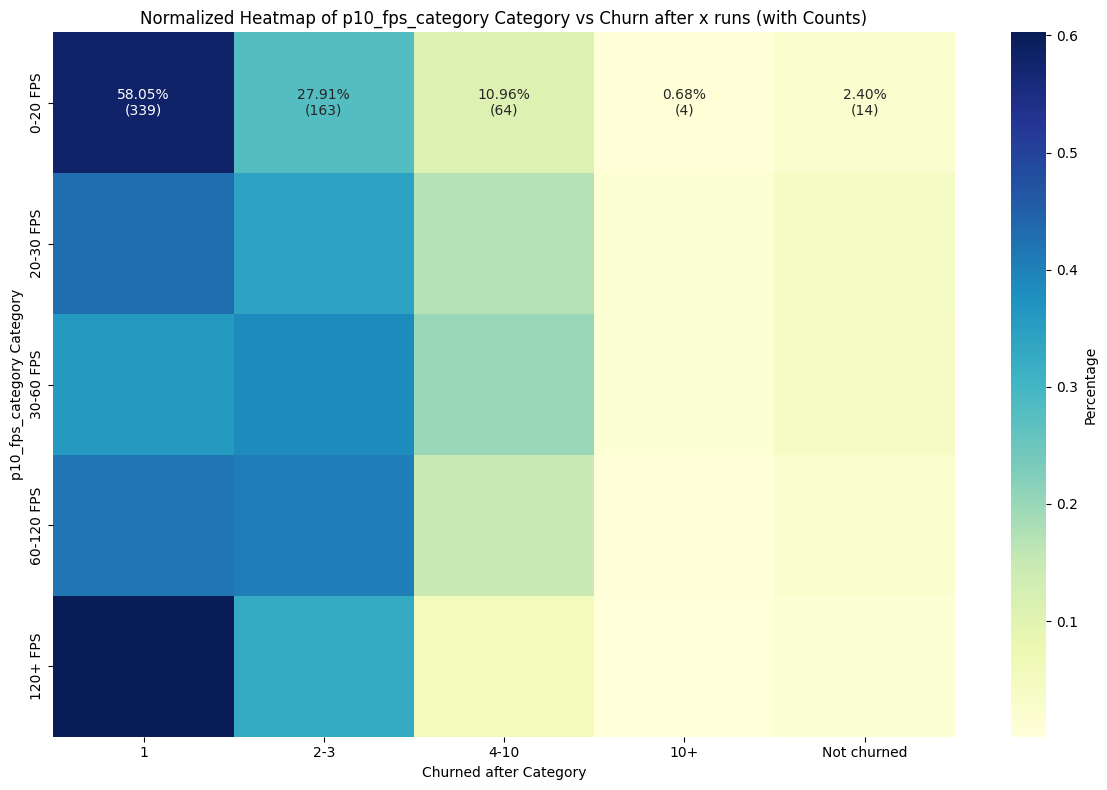

churn_bin                          1             2-3            4-10  \
median_ping_category                                                   
0-30 Ping                  nan%\n(0)       nan%\n(0)       nan%\n(0)   
30-60 Ping             35.70%\n(236)   44.78%\n(296)    13.46%\n(89)   
60-100 Ping            33.88%\n(726)   43.54%\n(933)   17.45%\n(374)   
100-200 Ping          40.00%\n(3236)  39.05%\n(3159)  16.81%\n(1360)   
200+ Ping             44.06%\n(2905)  36.03%\n(2376)  16.27%\n(1073)   

churn_bin                     10+   Not churned  
median_ping_category                             
0-30 Ping               nan%\n(0)     nan%\n(0)  
30-60 Ping             0.76%\n(5)   5.30%\n(35)  
60-100 Ping           1.40%\n(30)   3.73%\n(80)  
100-200 Ping          0.75%\n(61)  3.37%\n(273)  
200+ Ping             1.12%\n(74)  2.52%\n(166)  


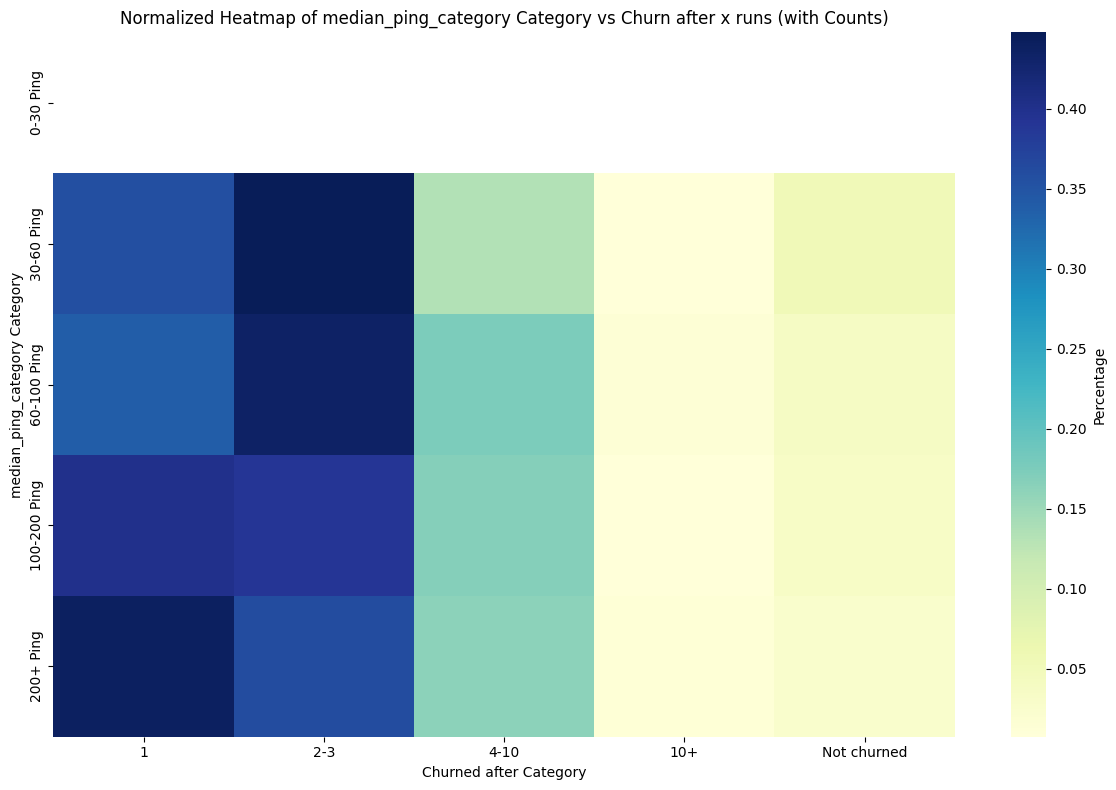

churn_bin                       1             2-3            4-10  \
p90_ping_category                                                   
0-30 Ping               nan%\n(0)       nan%\n(0)       nan%\n(0)   
30-60 Ping           50.00%\n(56)    34.82%\n(39)    10.71%\n(12)   
60-100 Ping         33.00%\n(464)   45.52%\n(640)   15.79%\n(222)   
100-200 Ping       37.09%\n(2510)  40.59%\n(2747)  17.75%\n(1201)   
200+ Ping          44.62%\n(4134)  36.05%\n(3340)  15.77%\n(1461)   

churn_bin                  10+   Not churned  
p90_ping_category                             
0-30 Ping            nan%\n(0)     nan%\n(0)  
30-60 Ping          0.00%\n(0)    4.46%\n(5)  
60-100 Ping        1.14%\n(16)   4.55%\n(64)  
100-200 Ping       0.99%\n(67)  3.58%\n(242)  
200+ Ping          0.94%\n(87)  2.62%\n(243)  


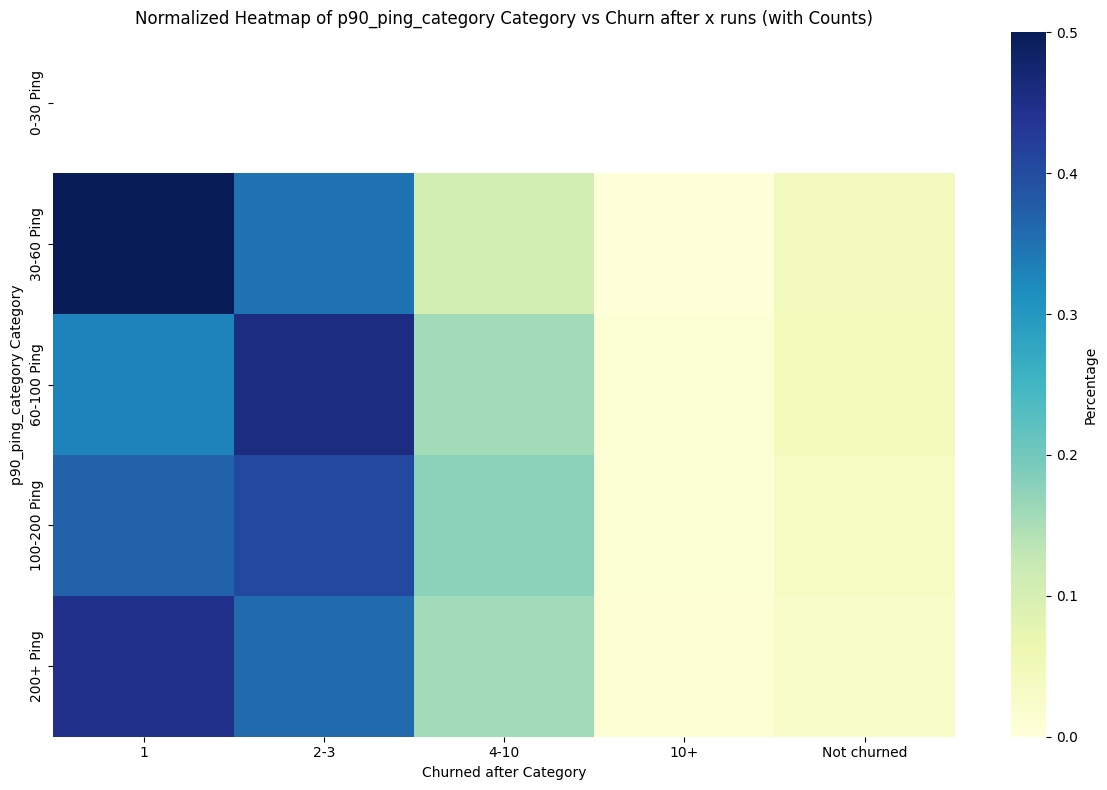

churn_bin                      1             2-3            4-10  \
min_fps_category                                                   
0-20 FPS           53.22%\n(364)   29.39%\n(201)    12.28%\n(84)   
20-30 FPS          39.05%\n(560)   34.38%\n(493)   19.67%\n(282)   
30-60 FPS         35.61%\n(2754)  39.37%\n(3045)  19.93%\n(1541)   
60-120 FPS        43.69%\n(3135)  40.25%\n(2888)   13.46%\n(966)   
120+ FPS           68.49%\n(376)   25.68%\n(141)     4.19%\n(23)   

churn_bin                  10+   Not churned  
min_fps_category                              
0-20 FPS            1.02%\n(7)   4.09%\n(28)  
20-30 FPS          2.02%\n(29)   4.88%\n(70)  
30-60 FPS         1.33%\n(103)  3.76%\n(291)  
60-120 FPS         0.43%\n(31)  2.17%\n(156)  
120+ FPS            0.00%\n(0)    1.64%\n(9)  


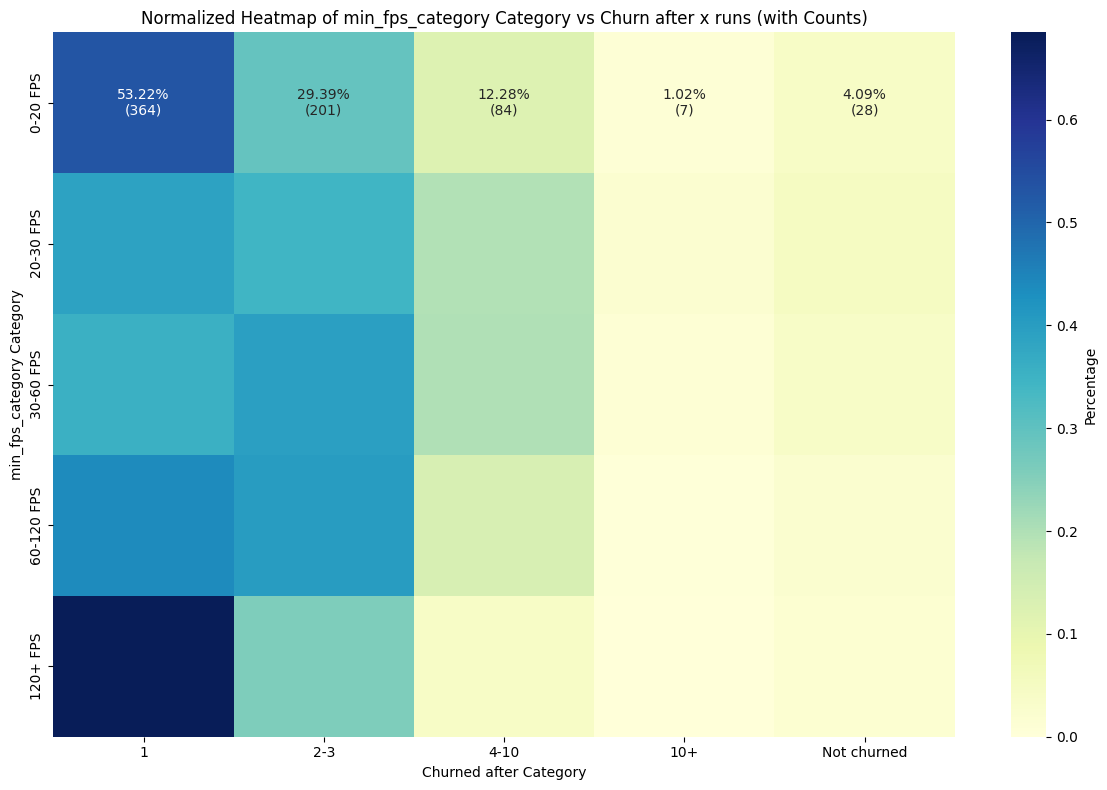

In [20]:
for category in categories:
    # Create a heatmap for median_fps_category vs runs_to_churn_category
    heatmap_data = df_agg.pivot_table(
        index=category,
        columns='churn_bin',
        aggfunc='size',
        fill_value=0,
        observed = False
    )

    # Normalize the heatmap data by row (percentage)
    heatmap_data_normalized = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

    # Combine normalized percentages and raw counts into a single DataFrame
    # Explicitly set the dtype of annot_data to 'object' to handle strings
    annot_data = heatmap_data_normalized.copy().astype('object')
    for row in heatmap_data.index:
        for col in heatmap_data.columns:
            percentage = f"{heatmap_data_normalized.loc[row, col]:.2%}"
            count = f"({heatmap_data.loc[row, col]})"
            annot_data.loc[row, col] = f"{percentage}\n{count}"
    print(annot_data)
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data_normalized, 
        annot=annot_data, 
        fmt="", 
        cmap="YlGnBu", 
        cbar_kws={'label': 'Percentage'}
    )
    plt.title(f"Normalized Heatmap of {category} Category vs Churn after x runs (with Counts)")
    plt.xlabel("Churned after Category")
    plt.ylabel(f"{category} Category")
    plt.tight_layout()
    plt.show()


In [21]:
""""
from sklearn.model_selection import GroupShuffleSplit,GroupKFold

n_splits = 5  # ~20% validation
splitter = GroupKFold(n_splits=n_splits)
groups = df["userId"]
X = df[features]  # Use the same df
y = df[target]  # Use the same df

for train_idx, val_idx in splitter.split(X, y, groups=groups):
    # Ensure validation sessions are AFTER training sessions for each user
    val_mask = df.iloc[val_idx].groupby("userId")["entryTime"].transform(
        lambda x: x > x.min()  # Validate on later sessions
    )
    val_idx = val_idx[val_mask]
    break  # Take first split for simplicity

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]"""

'"\nfrom sklearn.model_selection import GroupShuffleSplit,GroupKFold\n\nn_splits = 5  # ~20% validation\nsplitter = GroupKFold(n_splits=n_splits)\ngroups = df["userId"]\nX = df[features]  # Use the same df\ny = df[target]  # Use the same df\n\nfor train_idx, val_idx in splitter.split(X, y, groups=groups):\n    # Ensure validation sessions are AFTER training sessions for each user\n    val_mask = df.iloc[val_idx].groupby("userId")["entryTime"].transform(\n        lambda x: x > x.min()  # Validate on later sessions\n    )\n    val_idx = val_idx[val_mask]\n    break  # Take first split for simplicity\n\nX_train, X_val = X.iloc[train_idx], X.iloc[val_idx]\ny_train, y_val = y.iloc[train_idx], y.iloc[val_idx]'

In [22]:
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit,GroupKFold


# Reset the index so that positions align with .iloc
df = df_agg.reset_index(drop=True)

# Define feature set and target
features = ["median_fps", "min_fps", "p10_fps", "median_ping", "p90_ping"]
target = "churn_bin"

X = df[features]
y = df[target]

# Encode the target variable before split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode full dataset first

# Ensure that X and y_encoded have no NaNs 
X = X.fillna(X.median())
y_encoded = np.array(y_encoded)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(X, y_encoded, groups=df["userId"]):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]




In [23]:
# If y is a categorical Series:
if hasattr(y, "cat"):
    mapping = dict(enumerate(y.cat.categories))
    print(mapping)
else:
    mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print(mapping)

{0: '1', 1: '2-3', 2: '4-10', 3: '10+', 4: 'Not churned'}


In [163]:
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Make sure groups (userId) align with X and y
groups = df["userId"]

# Set up GroupKFold for 5-fold CV
n_splits = 5
cv = GroupKFold(n_splits=n_splits)

def objective(trial):
    # Define the search space for hyperparameters
    param = {
        "verbosity": 0,
        "objective": "multi:softprob",  # Use softprob for multi-class probabilities
        "tree_method": "hist",  # Use "gpu_hist" if you have GPU available
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log=True)
    }

    # Update the number of classes based on the full target distribution
    param["num_class"] = len(np.unique(y_encoded))
    
    cv_log_losses = []
    
    # Loop over each fold
    for train_idx, val_idx in cv.split(X, y_encoded, groups=groups):
        # Here you can implement additional filtering on the validation set if desired.
        # For demonstration we use the full validation set.
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
        
        model = xgb.XGBClassifier(**param,
                                  eval_metric="mlogloss",
                                  early_stopping_rounds=50)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False  # Keep training logs silent
        )

        y_pred = model.predict_proba(X_val)
        loss = log_loss(y_val, y_pred)
        cv_log_losses.append(loss)
    
    # Return the average log loss across folds as the objective value
    return np.mean(cv_log_losses)

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# Print best trial details
print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Log Loss:", trial.value)
print("  Params:", trial.params)

# Retrieve best parameters to train a final model if desired
best_params = study.best_params


[I 2025-02-25 16:01:51,875] A new study created in memory with name: no-name-a3c7fd9e-32f7-42de-87b8-ae3c09d08f63


Class mapping: {'1': 0, '10+': 1, '2-3': 2, '4-10': 3, 'Not churned': 4}


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-02-25 16:02:38,573] Trial 0 finished with value: 1.5088025144504658 and parameters: {'n_estimators': 987, 'max_depth': 11, 'learning_rate': 0.00020878891888638406, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 0.0389532327685908, 'reg_lambda': 4.1764402667886794e-08, 'gamma': 0.017941177959246143}. Best is trial 0 with value: 1.5088025144504658.
[I 2025-02-25 16:03:02,740] Trial 1 finished with value: 1.363038095104084 and parameters: {'n_estimators': 579, 'max_depth': 10, 'learning_rate': 0.00110290662276373, 'subsample': 0.5, 'colsample_bytree': 0.9, 'reg_alpha': 0.025321955516004285, 'reg_lambda': 9.331404381512558e-07, 'gamma': 5.911154337947804e-08}. Best is trial 1 with value: 1.363038095104084.
[I 2025-02-25 16:03:09,079] Trial 2 finished with value: 1.0639008400095293 and parameters: {'n_estimators': 274, 'max_depth': 6, 'learning_rate': 0.0682961272845301, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.26479297031575333, 'reg_lambda': 3.49973835486

In [166]:
best_model = xgb.XGBClassifier(**best_params,
                                eval_metric="mlogloss",
                                early_stopping_rounds=50)

best_model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                verbose=False)

y_pred_test = best_model.predict_proba(X_test)
test_log_loss = log_loss(y_test, y_pred_test)
print("Final Test Log Loss:", test_log_loss)

Final Test Log Loss: 1.0718469647040723


In [24]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss

# Option 1: Baseline model with uniform random predictions
dummy_uniform = DummyClassifier(strategy='uniform', random_state=42)
dummy_uniform.fit(X_train, y_train)
y_pred_uniform = dummy_uniform.predict_proba(X_test)
baseline_log_loss_uniform = log_loss(y_test, y_pred_uniform)
print("Baseline (Uniform) Log Loss:", baseline_log_loss_uniform)

# Option 2: Baseline model predicting the most frequent class
dummy_most_frequent = DummyClassifier(strategy='most_frequent')
dummy_most_frequent.fit(X_train, y_train)
# The most frequent strategy does not output probabilities directly,
# so we create a probability distribution where the most frequent class
# is given probability 1 for every sample.
most_freq_class = dummy_most_frequent.predict(X_test)
# Create one-hot encoded probabilities for the most frequent predictions
import numpy as np
from sklearn.preprocessing import label_binarize

# Determine the unique classes
classes = np.unique(y_train)
y_pred_most_freq = label_binarize(most_freq_class, classes=classes)

# In case there's only one class predicted, we need to reshape
if y_pred_most_freq.ndim == 1:
    y_pred_most_freq = y_pred_most_freq.reshape(-1, 1)

baseline_log_loss_most_freq = log_loss(y_test, y_pred_most_freq)
print("Baseline (Most Frequent) Log Loss:", baseline_log_loss_most_freq)


Baseline (Uniform) Log Loss: 1.6094379124340996
Baseline (Most Frequent) Log Loss: 21.28174756422275


In [167]:
num_classes = len(np.unique(label_encoder.fit_transform(y_train)))

In [168]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values (use `explainer` directly for multi-class models)
shap_values = explainer(X)
type(shap_values)



shap._explanation.Explanation

For class: 0


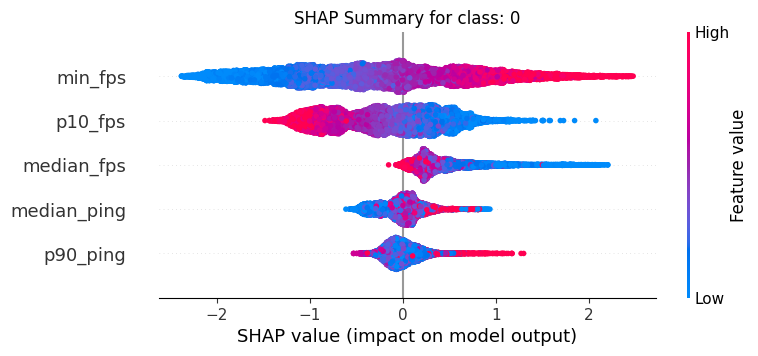

For class: 1


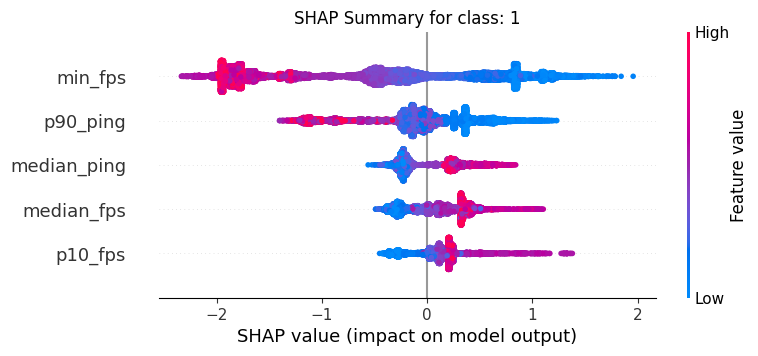

For class: 2


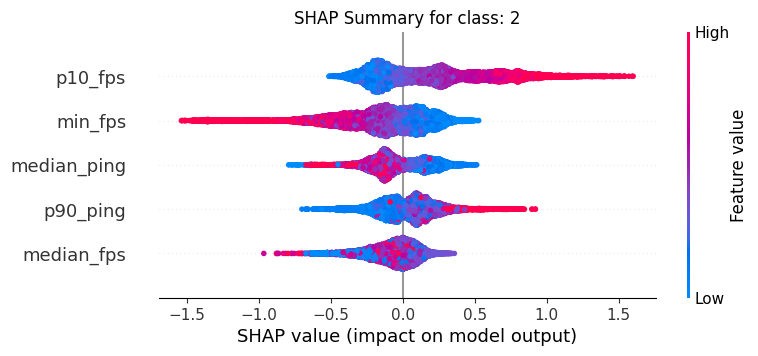

For class: 3


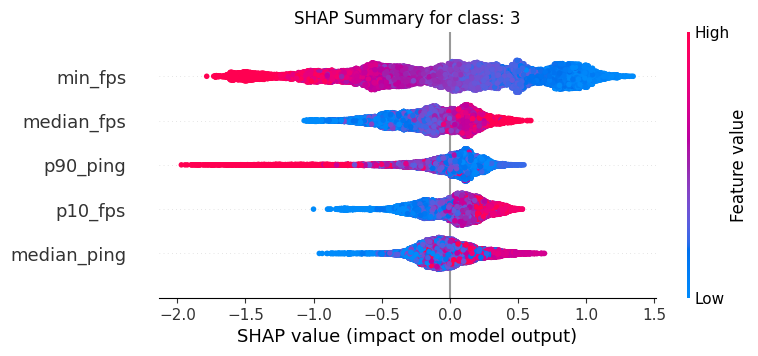

For class: 4


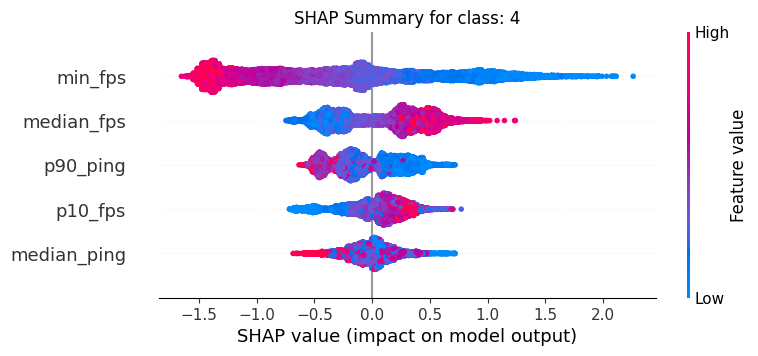

In [169]:

num_classes = shap_values.values.shape[2]  # or len(label_encoder.classes_)

for i in range(num_classes):
    class_shap = shap_values.values[..., i]  # SHAP values for class i
    print(f"For class: {label_encoder.classes_[i]}")
    
    shap.summary_plot(
        class_shap,
        X,  # or features=X if X is a DataFrame
        show=False  # avoid popping up each figure immediately
    )
    plt.title(f"SHAP Summary for class: {label_encoder.classes_[i]}")
    plt.show()

In [130]:
df[features].corr()

,historical_median_fps,historical_min_fps,historical_p10_fps,historical_median_ping,historical_p90_ping
historical_median_fps,1.000000,0.951570,0.974818,-0.170811,-0.147188
historical_min_fps,0.951570,1.000000,0.982754,-0.141047,-0.123357
historical_p10_fps,0.974818,0.982754,1.000000,-0.158634,-0.146062
historical_median_ping,-0.170811,-0.141047,-0.158634,1.000000,0.607885
historical_p90_ping,-0.147188,-0.123357,-0.146062,0.607885,1.000000


In [174]:

print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
